# Temperature profiles
The purpose of this notebook is to plot latittude temperature profiles using the ESM3 temperature data from historic simulations.

The [plotted data](#Presentation-of-data) can be found in the bottom half of the document.

#### Dask Import

<br>

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33383")
client

Client Scheduler: tcp://127.0.0.1:33383 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 7 Memory: 45.10 GB


#### Choices for data

In [2]:
#Experiment data for analysis
dataVariableId = 'thetao'
dataExperimentId = 'historical'
dataSourceID = 'E3SM-1-0'

#Ocean Area data for averaging 
areaVariableId = 'areacello'
areaSourceId = 'CESM2'
areaDataSetNo = 1 #First database in results to be used

#Custom Variables
latSel = slice(-89.5,-29.5) #Selected latitude to be investigated
levSel = 5.0

<br>

#### Imports

In [3]:
import cartopy.crs as ccrs
import dask.dataframe as dd
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import zarr

from dask import delayed
from matplotlib.pyplot import cm
print("Imports complete")

Imports complete


<br>

#### Accessing Dataset Database

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print("Database accessed")

Database accessed


<br>

#### Filtering for relevant data sets
ESM3 data sets

In [5]:
dfFilt = df[df.variable_id.eq(dataVariableId) & df.experiment_id.eq(dataExperimentId) & df.source_id.eq(dataSourceID)]
print(str(len(dfFilt))+" datasets found.")
dfFilt

5 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
270900,CMIP,E3SM-Project,E3SM-1-0,historical,r1i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190826
271560,CMIP,E3SM-Project,E3SM-1-0,historical,r2i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20190830
401370,CMIP,E3SM-Project,E3SM-1-0,historical,r4i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
401372,CMIP,E3SM-Project,E3SM-1-0,historical,r3i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200129
430597,CMIP,E3SM-Project,E3SM-1-0,historical,r5i1p1f1,Omon,thetao,gr,gs://cmip6/CMIP6/CMIP/E3SM-Project/E3SM-1-0/hi...,NaN,20200429


<br>
Ocean area data to be used for averaging

In [6]:
dfArea = df[df.variable_id.eq(areaVariableId) & df.source_id.eq(areaSourceId)]
print(str(len(dfArea))+" datasets found.")
dfArea.head()

73 datasets found.


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
57950,CMIP,NCAR,CESM2,historical,r3i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
57951,CMIP,NCAR,CESM2,historical,r3i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r3...,NaN,20190308
58402,CMIP,NCAR,CESM2,historical,r5i1p1f1,Ofx,areacello,gr,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
58403,CMIP,NCAR,CESM2,historical,r5i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r5...,NaN,20190308
59011,CMIP,NCAR,CESM2,historical,r6i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r6...,NaN,20190308


<br>

#### Opening all datafiles
ESM3 data

In [7]:
fileSetList = []
for i in range(len(dfFilt)):
    zstore = dfFilt.zstore.values[i]
    mapper = fsspec.get_mapper(zstore)
    fileRaw = xr.open_zarr(mapper, consolidated=True)
    fileSetList.append(fileRaw)
fileCount = len(fileSetList)
if fileCount:
    print(str(fileCount)+" ESM3 data sets opened")
else:
    print("No ESM3 data sets opened")

5 ESM3 data sets opened


Ocean Area data

In [8]:
dsArea = xr.open_zarr(fsspec.get_mapper(dfArea.zstore.values[areaDataSetNo]), consolidated=True)
dataAreaRaw = dsArea.areacello
print("Ocean Area data loaded")

Ocean Area data loaded


<br>

#### Combine data sets into one xarray

In [9]:
for i in range(fileCount): #Formatting dates into np.datetime64 format
    startDateIterate = np.datetime64(fileSetList[i]['time'].values[0],'M')
    endDateIterate = np.datetime64(fileSetList[i]['time'].values[-1],'M') + np.timedelta64(1,'M')
    fileSetList[i]['time']=('time', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]'))
    fileSetList[i]['time_bnds']=('time_bnds', np.arange(startDateIterate, endDateIterate, dtype='datetime64[M]')) 
fileSet = xr.combine_nested(fileSetList, concat_dim='RunID') #Combining data sets
print("Data sets successfully merged")
#fileSet #Uncomment to see full data set

Data sets successfully merged


<br>

#### Selection of Data

In [10]:
dataFiltLat = fileSet.thetao.sel(lat=latSel) #Selection of latitude
#dataFiltLatLev = fileSet.thetao.sel(lev=levSel) #Selection of depth
dataFiltFull = dataFiltLat.reset_coords(drop=True) #Removes lev if single value
print("Finished data selection")
#dataFiltFull #Uncomment to see filtered data set

Finished data selection


<br>

#### Time identification

In [11]:
globalStartDate = dataFiltFull["time"][0].values
globalDateInc = dataFiltFull["time"][1].values - globalStartDate
#np.datetime64(globalDateInc,'D')
globalEndDateIn = dataFiltFull["time"][-1].values
globalEndDateOut = globalEndDateIn + globalDateInc

globalStartDateStr = str(globalStartDate)[:7]
globalEndDateInStr = str(globalEndDateIn)[:7]
globalEndDateOutStr = str(globalEndDateOut)[:7]

print("Data start date: "+globalStartDateStr)
print("Data end date (included): "+str(globalEndDateInStr))
print("Data end date (excluded): "+str(globalEndDateOutStr))
print("Data increments in steps of "+str(globalDateInc))

Data start date: 1850-01
Data end date (included): 2014-12
Data end date (excluded): 2015-01
Data increments in steps of 2678400000000000 nanoseconds


<br>

#### Calculation
Functions: <br>


Global Data: <br>
dataAreaSH - Ocean area data for the selected latitudes ([latSec](#Choices-for-data)), taken from first [areacello](#Accessing-Dataset-Database) database <br>
totalArea - The sum of all the area in dataAreaSH ([see above](#Calculation))

In [12]:
def floatLocation(runID, plotNo):
    temp = dataFiltFull.copy()
    floatLocData = temp.sel(lev=5.0,RunID = runID )
    floatLocData = floatLocData.sel(time = slice('2000-01',globalEndDateInStr))
    floatLocData = floatLocData.mean('time')
    floatLocData = floatLocData.reset_coords(drop=True)
    floatLocData = floatLocData.notnull()
    floatLocationPlot(floatLocData, runID, plotNo)
    return floatLocData

print("Calculation functions defined")

Calculation functions defined


<br>

#### Presentation of data
Functions: <br>


In [25]:
def floatLocationPlot(dataSet, runID, plotNo):
    '''Displays Ocean temperature for given data set on a map, prints mean ocean temperature'''
    plt.figure(plotNo, figsize= (7,7))
    p=dataSet.plot(x='lon',y='lat',transform=ccrs.PlateCarree(),cmap='RdBu_r',robust=True,
    subplot_kws={'projection': ccrs.SouthPolarStereo()})
    p.axes.gridlines()
    #p.axes.coastlines()
    plt.title("Southern Ocean float location ("+str(runID)+")")

    
print("Plotting functions defined")

Plotting functions defined


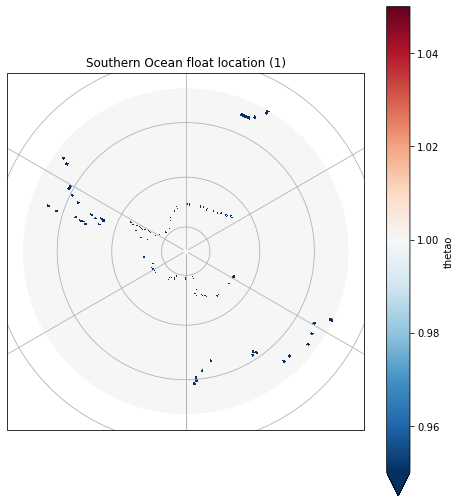

In [24]:
x = floatLocation(1,0)

In [15]:
x

<xarray.DataArray 'thetao' (lat: 61, lon: 360)>
dask.array<invert, shape=(61, 360), dtype=bool, chunksize=(61, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 ... -32.5 -31.5 -30.5 -29.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

In [16]:
y = dataFiltFull.sel(lat=-32.5, lon=(360-60.5), time='2000-01', RunID=1, lev=5.0)
y.values

array([1.], dtype=float32)

In [21]:
x = dataFiltFull.sel(lat=-32.5, lon=22.5, time='2000-01', RunID=1, lev=5.0)
x.values

array([1.], dtype=float32)